In [1]:
from google.colab import drive 
drive.mount('content/')


Mounted at content/


In [2]:
!unzip /content/content/MyDrive/NER_Data/archive_2.zip


Archive:  /content/content/MyDrive/NER_Data/archive_2.zip
  inflating: ner.csv                 
  inflating: ner_dataset.csv         



**Importing the dataset for named entity recognition model**

The goal of a named entity recognition (NER) system is to identify all textual mentions of the named entities. 

This can be broken down into two sub-tasks: 

    1. identifying the boundaries of the NE
    2. identifying its type.

**Named entity recognition** is a task that is well-suited to the type of classifier-based approach. In particular, a tagger can be built that labels each word in a sentence using the IOB format, where chunks are labelled by their appropriate type.


The IOB Tagging system contains tags of the form:

    B - {CHUNK_TYPE} – for the word in the Beginning chunk
    I - {CHUNK_TYPE} – for words Inside the chunk
    O – Outside any chunk
    The IOB tags are further classified into the following classes –

    geo = Geographical Entity
    org = Organization
    per = Person
    gpe = Geopolitical Entity
    tim = Time indicator
    art = Artifact
    eve = Event
    nat = Natural Phenomenon

In [ ]:
!pip install -q sklearn-crfsuite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 44.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np

#Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
plt.style.use("ggplot")
%config InlineBackend.figure_format = 'svg'

#Modeling
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import GridSearchCV

# from sklearn_crfsuite import CRF, scorers, metrics
# import sklearn_crfsuite
# from sklearn_crfsuite import scorers
# from sklearn_crfsuite import metrics
# from sklearn_crfsuite.metrics import flat_classification_report

In [ ]:
df = pd.read_csv('ner_dataset.csv', encoding="latin1")
df.columns = df.iloc[0]
df = df[1:]
df.columns = ['Sentence #','Word','POS','Tag']
df = df.rename(columns={"Sentence #": "Sentence"})
df = df.reset_index(drop=True)
#so we are basically having only those rows where sentence column is not null
#so we are basically having only those rows where sentence column is not null
data = df[df['Sentence'].notnull()]
data.head()

,Sentence,Word,POS,Tag
23,Sentence: 2,Families,NNS,O
53,Sentence: 3,They,PRP,O
67,Sentence: 4,Police,NNS,O
82,Sentence: 5,The,DT,O
107,Sentence: 6,The,DT,O


The dataset has the following columns or features -

    Index - Index numbers for each word [Numeric type]
    Sentence # - The number of sentences in the dataset (We will find the number of sentences below) [Numeric type]
    Word - The words in the sentence [Character type]
    POS - Parts Of Speech tags, these are tags given to the type of words as per the Penn TreeBank Tagset [Categorical type]
    Tag -The tags given to each word based on the IOB tagging system described above (Target variable) [Categorical type]

In [ ]:
# A class to retrieve the sentences from the dataset
class getsentence(object):
    
    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

Stentence looks like : [('He', 'PRP', 'O')]
Maximum sequence length: 1


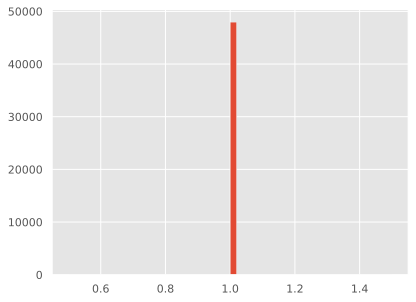

In [ ]:
getter = getsentence(data)
sentences = getter.sentences
print(f"Stentence looks like : {sentences[5]}")
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

# Check how long sentences are so that we can pad them
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [ ]:
#Words tagged as B-org
data.loc[data['Tag'] == 'B-org', 'Word'].head(5)

1371    Halliburton
1482            VOA
1623           ABAC
1682           ABAC
1800           ABAC
Name: Word, dtype: object

In [ ]:
data.head()

,Sentence,Word,POS,Tag
23,Sentence: 2,Families,NNS,O
53,Sentence: 3,They,PRP,O
67,Sentence: 4,Police,NNS,O
82,Sentence: 5,The,DT,O
107,Sentence: 6,The,DT,O


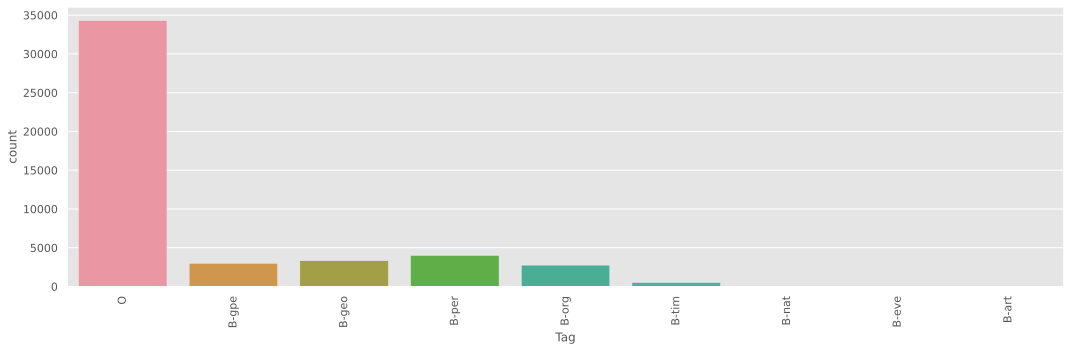

In [ ]:
#Words distribution across Tags
plt.figure(figsize=(15, 5))
ax = sns.countplot(x='Tag', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

most of the words are tagged as outside of any chunk. These words can be considered as fillers and their presence might impact the classifier performance as well. Lets check the dataset again without the O tags.

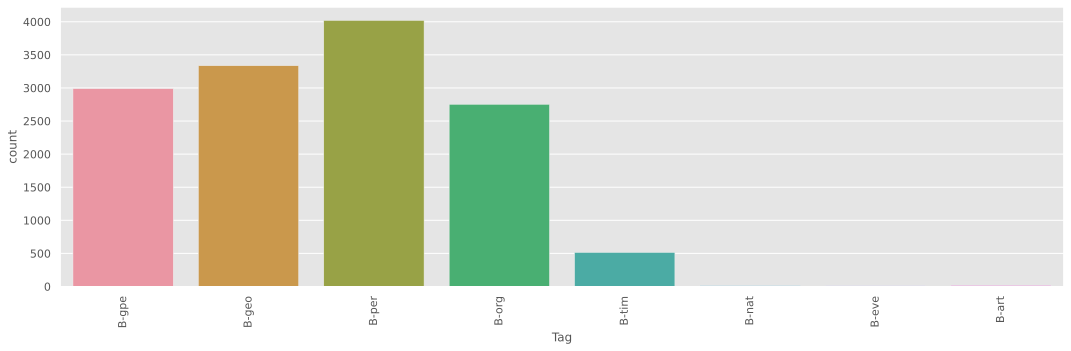

In [ ]:
#Words distribution across Tags without O tag
plt.figure(figsize=(15, 5))
ax = sns.countplot(x='Tag', data=data.loc[data['Tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

So our dataset mostly contains words related to geopolitical entities, geographical locations and person names.

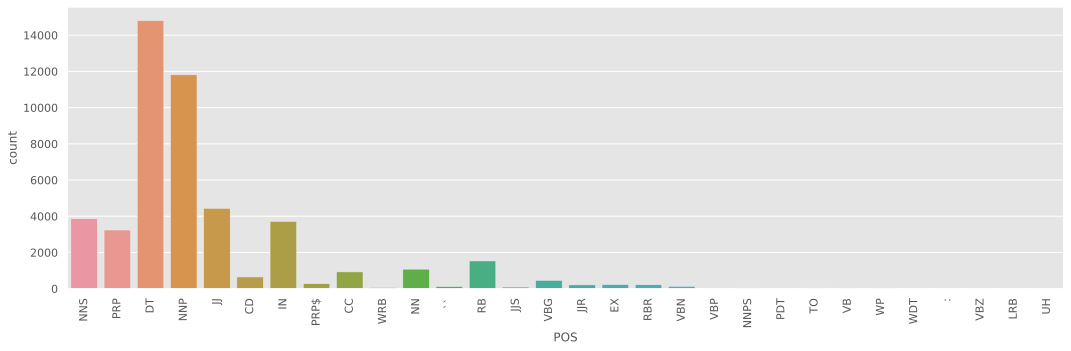

In [ ]:
#Words distribution across POS
plt.figure(figsize=(15, 5))
ax = sns.countplot(x='POS', data=data, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

## Random Forest

In [ ]:
#Simple feature map to feed arrays into the classifier. 
def feature_map(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(),  word.isalpha()])
    
#We divide the dataset into train and test sets
words = [feature_map(w) for w in data["Word"].values.tolist()]
tags = data["Tag"].values.tolist()
print(f"words : {words[5]}")
print(f"tags : {tags[5]}")
n_words = len(words)
n_tags = len(tags)
print(f"n_words : {n_words}  & n_tags : {n_tags}")

words : [1 0 0 3 0 1]
tags : O
n_words : 47958  & n_tags : 47958


In [ ]:
#Random Forest classifier
clf = RandomForestClassifier(n_estimators=20)
clf.fit(X=words, y=tags)
pred = cross_val_predict(clf,X=words, y=tags, cv=5)
#Lets check the performance 
from sklearn.metrics import classification_report
report = classification_report(y_pred=pred, y_true=tags)
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        18
       B-eve       0.00      0.00      0.00        10
       B-geo       0.51      0.10      0.16      3335
       B-gpe       0.00      0.00      0.00      2989
       B-nat       0.00      0.00      0.00        11
       B-org       0.80      0.20      0.32      2752
       B-per       0.99      0.39      0.56      4019
       B-tim       0.00      0.00      0.00       515
           O       0.76      1.00      0.86     34309

    accuracy                           0.76     47958
   macro avg       0.34      0.19      0.21     47958
weighted avg       0.71      0.76      0.69     47958



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
test_string = "This is Egyptian , He knows it" 
test_words = [feature_map(w) for w in test_string.title().split()]

prediction = clf.predict(test_words)
prediction

array(['O', 'O', 'O', 'O', 'O', 'O', 'O'], dtype='<U5')

# Bidirectional-LSTM 

In [ ]:
df = pd.read_csv("ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)
dataset=df.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word',"pos",'shape'],axis=1)

dataset.head(5)

<ipython-input-27-0f7eab09bc03>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv("ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)
Skipping line 281837: expected 25 fields, saw 34



,sentence_idx,word,tag
0,1.0,Thousands,O
1,1.0,of,O
2,1.0,demonstrators,O
3,1.0,have,O
4,1.0,marched,O


In [ ]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

Stentence looks like : [('The', 'O'), ('party', 'O'), ('is', 'O'), ('divided', 'O'), ('over', 'O'), ('Britain', 'B-gpe'), ("'s", 'O'), ('participation', 'O'), ('in', 'O'), ('the', 'O'), ('Iraq', 'B-geo'), ('conflict', 'O'), ('and', 'O'), ('the', 'O'), ('continued', 'O'), ('deployment', 'O'), ('of', 'O'), ('8,500', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('in', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O'), ('The', 'O'), ('party', 'O'), ('is', 'O'), ('divided', 'O'), ('over', 'O'), ('Britain', 'B-gpe'), ("'s", 'O'), ('participation', 'O'), ('in', 'O'), ('the', 'O'), ('Iraq', 'B-geo'), ('conflict', 'O'), ('and', 'O'), ('the', 'O'), ('continued', 'O'), ('deployment', 'O'), ('of', 'O'), ('8,500', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('in', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]
Maximum sequence length: 140


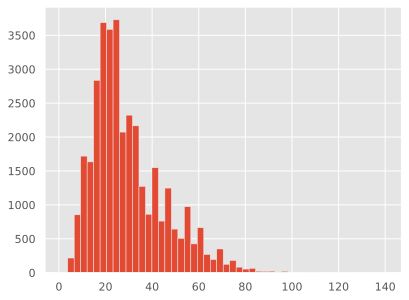

In [ ]:
getter = SentenceGetter(dataset)
sentences = getter.sentences
print(f"Stentence looks like : {sentences[5]}")
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

# Check how long sentences are so that we can pad them


plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [ ]:
words = list(set(dataset["word"].values))
words.append("ENDPAD")
print(f"words : {words[:5]}")
tags = list(set(dataset["tag"].values))
print(f"tags : {tags[:5]}")
n_words = len(words)
n_tags = len(tags)
print(f"n_words : {n_words}  & n_tags : {n_tags}")

words : ['rank-and-file', 'challenged', 'plunge', 'Asghari', 'Areas']
tags : ['I-gpe', 'B-eve', 'B-per', 'B-gpe', 'I-nat']
n_words : 30174  & n_tags : 18


**Converting words to numbers and numbers to words**

In [ ]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
print(f'Obama : {word2idx["Obama"]} , O : {tag2idx["O"]}')

Obama : 2929 , O : 16


In [ ]:
sentences[5]

[('The', 'O'),
 ('party', 'O'),
 ('is', 'O'),
 ('divided', 'O'),
 ('over', 'O'),
 ('Britain', 'B-gpe'),
 ("'s", 'O'),
 ('participation', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('Iraq', 'B-geo'),
 ('conflict', 'O'),
 ('and', 'O'),
 ('the', 'O'),
 ('continued', 'O'),
 ('deployment', 'O'),
 ('of', 'O'),
 ('8,500', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('in', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O'),
 ('The', 'O'),
 ('party', 'O'),
 ('is', 'O'),
 ('divided', 'O'),
 ('over', 'O'),
 ('Britain', 'B-gpe'),
 ("'s", 'O'),
 ('participation', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('Iraq', 'B-geo'),
 ('conflict', 'O'),
 ('and', 'O'),
 ('the', 'O'),
 ('continued', 'O'),
 ('deployment', 'O'),
 ('of', 'O'),
 ('8,500', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('in', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from tensorflow.keras import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

from keras.models import load_model

In [ ]:

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=140, sequences=X, padding="post",value=n_words - 1)
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=140, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=n_tags) for i in y]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:


input = Input(shape=(maxlen,))
model = Embedding(input_dim=n_words, output_dim=maxlen, input_length=maxlen)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer
model = Model(input, out)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140)]             0         
                                                                 
 embedding (Embedding)       (None, 140, 140)          4224360   
                                                                 
 dropout (Dropout)           (None, 140, 140)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 140, 200)         192800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 140, 18)          3618      
 ibuted)                                                         
                                                                 
Total params: 4,420,778
Trainable params: 4,420,778
Non-train

In [ ]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=3, validation_split=0.2, verbose=1)

Epoch 1/3
704/704 [==============================] - 769s 1s/step - loss: 0.1263 - accuracy: 0.9749 - val_loss: 0.0454 - val_accuracy: 0.9878
Epoch 2/3
704/704 [==============================] - 715s 1s/step - loss: 0.0308 - accuracy: 0.9913 - val_loss: 0.0288 - val_accuracy: 0.9916
Epoch 3/3
704/704 [==============================] - 711s 1s/step - loss: 0.0204 - accuracy: 0.9939 - val_loss: 0.0265 - val_accuracy: 0.9921


In [ ]:
i = 0
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:14}: {}".format(words[w],tags[pred]))

p[0]

1/1 [==============================] - 1s 613ms/step
Word           (True ): Pred
On            : O
the           : O
political     : O
front         : O
,             : O
Iraq          : B-geo
's            : O
main          : O
Shi'ite       : O
alliance      : O
,             : O
which         : O
swept         : O
the           : O
January       : B-tim
30            : O
elections     : O
,             : O
is            : O
finalizing    : O
a             : O
deal          : O
with          : O
Kurdish       : O
leaders       : O
to            : O
form          : O
a             : O
coalition     : O
ahead         : O
of            : O
the           : O
new           : O
parliament    : O
's            : O
first         : O
session       : O
next          : O
Wednesday     : B-tim
.             : O
On            : O
the           : O
political     : O
front         : O
,             : O
Iraq          : B-geo
's            : O
main          : O
Shi'ite       : O
alliance      : O
, 

array([16, 16, 16, 16, 16,  5, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16,  5, 16, 16, 16, 16, 16,
       16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16])

In [ ]:
model.save('ner_bilstm.h5')
del model  

In [3]:
import shutil

shutil.copy("/content/content/MyDrive/NER_Data/ner_bilstm.h5",".")

'./ner_bilstm.h5'

In [11]:
model = load_model('ner_bilstm.h5')
dataset = pd.read_csv("ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)
words = list(set(dataset["word"].values))
tags = list(set(dataset["tag"].values))
words.append("ENDPAD")
word2idx = {w: i for i, w in enumerate(words)}
maxlen = 140 # if we're only doing inference
model.summary()

<ipython-input-11-e3e251d1c72c>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv("ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)
Skipping line 281837: expected 25 fields, saw 34



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140)]             0         
                                                                 
 embedding (Embedding)       (None, 140, 140)          4224360   
                                                                 
 dropout (Dropout)           (None, 140, 140)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 140, 200)         192800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 140, 18)          3618      
 ibuted)                                                         
                                                                 
Total params: 4,420,778
Trainable params: 4,420,778
Non-train

## Test on custom data

In [13]:
# multiple_custom_data = ["This is a test sentence. Do NER on it", "Don't forget to put <ENDPAD>","Can it detect U.S ?","Monday is a week day",
#                "The Indian Space Research Organisation or is the national space agency of India, headquartered in Bengaluru. It operates under Department of Space which is directly overseen by the Prime Minister of India while Chairman of ISRO acts as executive of DOS as well."]

In [17]:
custom_data = ["The Indian Space Research Organisation or is the national space agency of India, headquartered in Bengaluru. It operates under Department of Space which is directly overseen by the Prime Minister of India while Chairman of ISRO acts as executive of DOS as well."]

In [19]:

# # Add 'ENDPAD' token to the words list
# words.append("ENDPAD")
n_words = len(words)


# Preprocess the custom data
custom_sequences = [[word2idx.get(word, n_words - 1) for word in sentence.split()] for sentence in custom_data]
custom_sequences = pad_sequences(maxlen=maxlen, sequences=custom_sequences, padding="post", value=n_words - 1)

# Predict tags for the custom data
predictions = model.predict(np.array(custom_sequences))
predicted_tags = np.argmax(predictions, axis=-1)

# Map tag indices back to the original tags
predicted_tags = [[tags[idx] for idx in sentence] for sentence in predicted_tags]

# Print the results
for sentence, tags in zip(custom_data, predicted_tags):
    words = sentence.split()
    print("Sentence:", sentence)
    print("Word\t\tTag")
    for word, tag in zip(words, tags):
        print(f"{word}\t\t{tag}")
    print()

1/1 [==============================] - 0s 80ms/step
Sentence: The Indian Space Research Organisation or is the national space agency of India, headquartered in Bengaluru. It operates under Department of Space which is directly overseen by the Prime Minister of India while Chairman of ISRO acts as executive of DOS as well.
Word		Tag
The		I-tim
Indian		I-tim
Space		I-tim
Research		I-tim
Organisation		I-tim
or		I-tim
is		I-tim
the		I-tim
national		I-tim
space		I-tim
agency		I-tim
of		I-tim
India,		I-tim
headquartered		I-tim
in		I-tim
Bengaluru.		I-tim
It		I-tim
operates		I-tim
under		I-tim
Department		I-tim
of		I-tim
Space		I-tim
which		I-tim
is		I-tim
directly		I-tim
overseen		I-tim
by		I-tim
the		I-tim
Prime		I-tim
Minister		I-tim
of		I-tim
India		I-tim
while		I-tim
Chairman		I-tim
of		I-tim
ISRO		I-tim
acts		I-tim
as		I-tim
executive		I-tim
of		I-tim
DOS		I-tim
as		I-tim
well.		I-tim



In [3]:
import spacy
from spacy import displacy

NER = spacy.load("en_core_web_sm")

In [7]:
text1= NER(custom_data[-1])

for word in text1.ents:
    print(word.text,word.label_)
displacy.render(text1,style="ent",jupyter=True)

The Indian Space Research Organisation ORG
India GPE
Bengaluru GPE
Department of Space ORG
India GPE
ISRO ORG
DOS ORG
